In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from func import *

# Read data

In [2]:
# Read graph
edgelist = np.loadtxt("data/portland-sub/portlandsub_edgelist.txt", dtype=np.int)

G = nx.Graph()
G.add_edges_from(edgelist)

In [3]:
n = G.number_of_nodes()

# Create list of lists representation
ll = [[] for _ in range(n)]
for i in range(1,n+1):
    for j in G.neighbors(i):
            ll[i-1].append(int(j))

In [4]:
# Read pre-computed edge betweenness measures
shortest_path_betweenness = read_betweenness("data/portland-sub/portlandsub_shortest_path_betweenness.txt", edgelist)
current_flow_betweenness = read_betweenness("data/portland-sub/portlandsub_current_flow_betweenness.txt", edgelist)
local25_betweenness = read_betweenness("data/portland-sub/portlandsub_local25_betweenness.txt", edgelist)
local10_betweenness = read_betweenness("data/portland-sub/portlandsub_local10_betweenness.txt", edgelist)
local02_betweenness = read_betweenness("data/portland-sub/portlandsub_local02_betweenness.txt", edgelist)

# Read pre-computed node eigenvector centrality
values = np.loadtxt("data/portland-sub/portlandsub_eigenvector_centrality.txt", dtype=np.float64)
eigenvector_centrality = dict((v,val) for v,val in zip(range(1,n+1),values))

# Intervention and simulation results

In [5]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main

In [6]:
Main.include("agentSEIR.jl")

<PyCall.jlwrap get_prob>

In [7]:
init_infectious = np.loadtxt("data/portland-sub/portlandsub_initial_cluster.txt", dtype=int)

## Scenario 1: $\beta$ is set to correspond to $R_0 = 2.5$

# Verify that beta is set appropriately
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=100, beta=0.055)
print(f'This should be around 0.89: {sum_R[-1]/n:.4f}')

### Sample epidemic curves

In [8]:
reduced_weight = .1
perc = .25
m = G.number_of_edges()

In [9]:
lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)

t_end = 80

init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)

_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.055, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)  

t_int = np.linspace(0, t_end, num=t_end+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R025.png", bbox_inches='tight', format='png', dpi=400)

t_end = 80
t_delay = 10
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.055)
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.055, rand_init=False, init_state=init_state)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state) 

t_ini = np.linspace(0, t_delay, num=t_delay+1)
t_int = np.linspace(t_delay, t_end, num=t_con+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R025_delay10.png", bbox_inches='tight', format='png', dpi=400)

### Simulation for interventions that start on day 0

reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 20
t_end = 200

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from cluster initialization
        """
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.055, init_infectious_nodes=init_infectious, rand_init=False)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_ui, init_infectious_nodes=init_infectious, rand_init=False)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_hd, init_infectious_nodes=init_infectious, rand_init=False)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_eg, init_infectious_nodes=init_infectious, rand_init=False)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_sp, init_infectious_nodes=init_infectious, rand_init=False)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_rw, init_infectious_nodes=init_infectious, rand_init=False)
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_lf10, init_infectious_nodes=init_infectious, rand_init=False)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_lf02, init_infectious_nodes=init_infectious, rand_init=False)
        """
        # the following lines run simulation from random initialization
        init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.023, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.023, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.023, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.023, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.023, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.023, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious) 
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.023, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.023, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R025.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R025.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

### Simulation for interventions that start on day 10

In [10]:
reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 50
t_end = 150
t_delay = 10
t_con = t_end - t_delay

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from cluster initialization
        """
        init_state, _, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.055, rand_init=False, init_infectious_nodes=init_infectious,)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.055, rand_init=False, init_state=init_state)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.055, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state)
        """
        # the following lines run simulation from random initialization
        init_state, _, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.055)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.055, rand_init=False, init_state=init_state)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.055, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

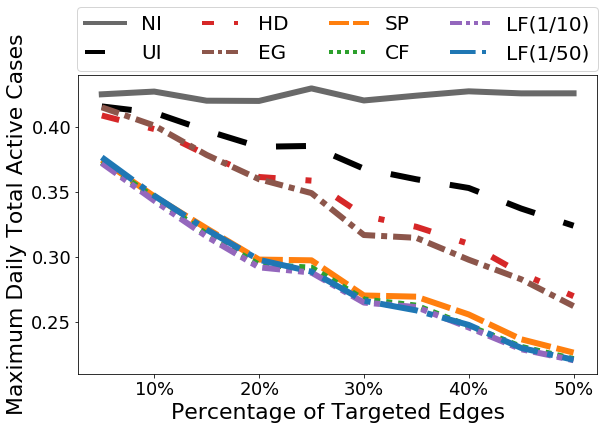

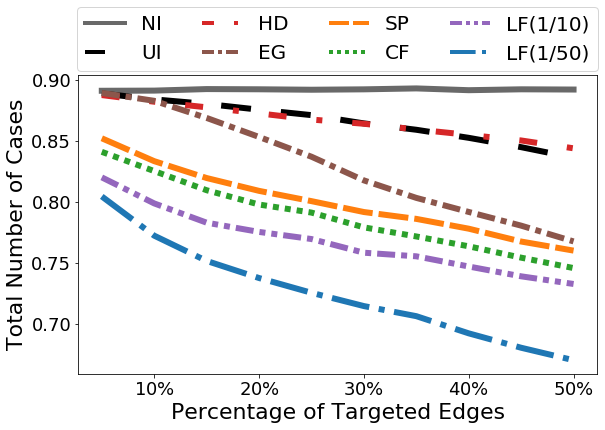

In [11]:
maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R025_delay10.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R025_delay10.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Scenario 2: $\beta$ is set to correspond to $R_0 = 1.5$

# Verify that beta is set appropriately
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=500, beta=0.0095)
print(f'This should be around 0.59: {sum_R[-1]/n:.4f}')

### Sample epidemic curves

In [12]:
reduced_weight = .1
perc = .25
m = G.number_of_edges()

In [13]:
lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)

t_end = 500

init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)

_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.0095, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)    

t_int = np.linspace(0, t_end, num=t_end+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R015.png", bbox_inches='tight', format='png', dpi=400)

t_end = 500
t_delay = 20
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.0095)
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.0095, rand_init=False, init_state=init_state)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state) 

t_ini = np.linspace(0, t_delay, num=t_delay+1)
t_int = np.linspace(t_delay, t_end, num=t_con+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R015_delay20.png", bbox_inches='tight', format='png', dpi=400)

### Simulation for interventions that start on day 0

reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 20
t_end = 1000

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from random initialization
        init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.0095, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious) 
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.0095, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R015.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R015.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

### Simulation for interventions that start on day 20

In [14]:
reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 50
t_end = 1000
t_delay = 20
t_con = t_end - t_delay

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from random initialization
        init_state, _, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.0095)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.0095, rand_init=False, init_state=init_state)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.0095, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

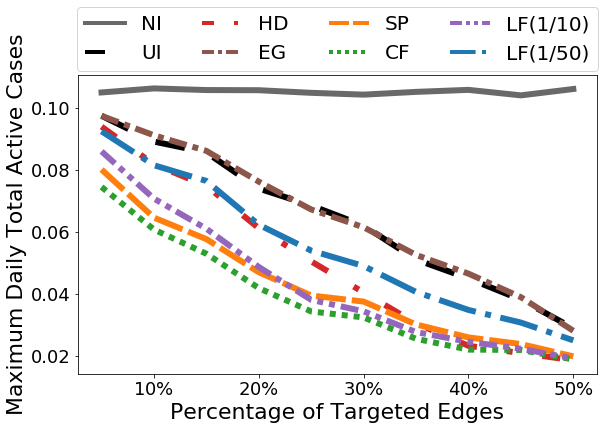

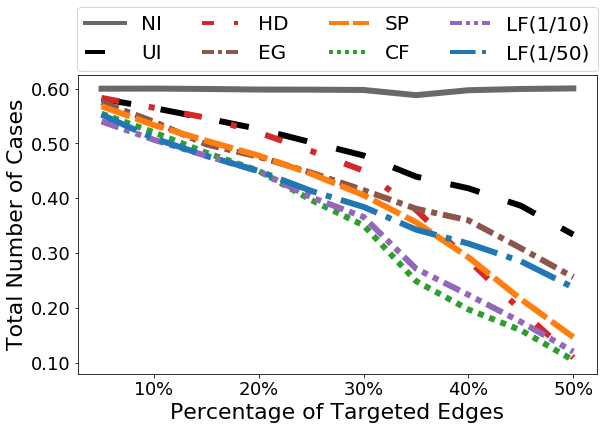

In [15]:
maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R015_delay20.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks((.1, .2, .3, .4, .5, .6), ('0.10', '0.20', '0.30', '0.40', '0.50', '0.60'), size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R015_delay20.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Scenario 3: $\beta$ is set to correspond to $R_0 = 3.5$

# Verify that beta is set appropriately
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=100, beta=0.18)M
print(f'This should be around 0.966: {sum_R[-1]/n:.4f}')

### Sample epidemic curves

In [16]:
reduced_weight = .1
perc = .25
m = G.number_of_edges()

In [17]:
lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)

t_end = 60

init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)

_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.18, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)    

t_int = np.linspace(0, t_end, num=t_end+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R035.png", bbox_inches='tight', format='png', dpi=400)

t_end = 60
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.18)
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.18, rand_init=False, init_state=init_state)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state) 

t_ini = np.linspace(0, t_delay, num=t_delay+1)
t_int = np.linspace(t_delay, t_end, num=t_con+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R035_delay5.png", bbox_inches='tight', format='png', dpi=400)

### Simulation for interventions that start on day 0

reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 20
t_end = 100

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from random initialization
        init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.18, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious) 
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.18, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R035.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R035.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [18]:
reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 50
t_end = 100
t_delay = 5
t_con = t_end - t_delay

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from random initialization
        init_state, _, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.18)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.18, rand_init=False, init_state=init_state)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.18, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

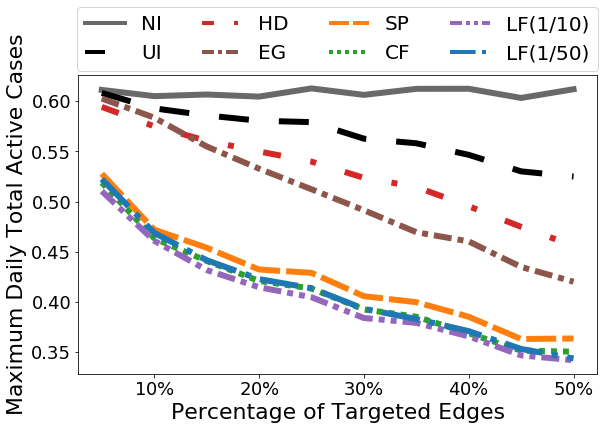

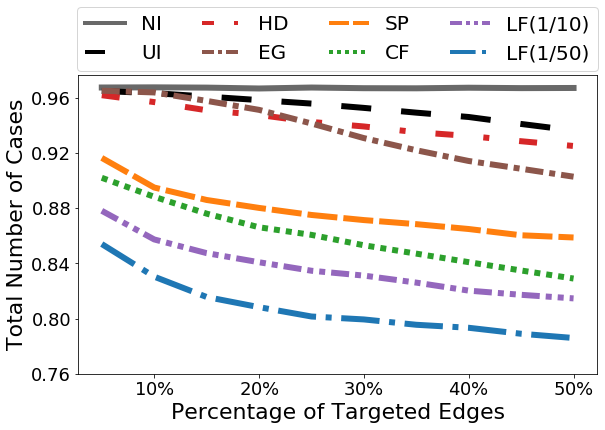

In [19]:
maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R035_delay5.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks((.76, .80, .84, .88, .92, .96), size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R035_delay5.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

## Scenario 4: $\beta$ is set to correspond to $R_0 = 4.5$

# Verify that beta is set appropriately
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=100, beta=0.35)
print(f'This should be around 0.99: {sum_R[-1]/n:.4f}')

### Sample epidemic curves

In [20]:
reduced_weight = .1
perc = .25
m = G.number_of_edges()

In [21]:
lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)

t_end = 60

init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)

_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.35, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)    

t_int = np.linspace(0, t_end, num=t_end+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R045.png", bbox_inches='tight', format='png', dpi=400)

t_end = 60
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.35)
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.35, rand_init=False, init_state=init_state)
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
_, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)  
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state) 

t_ini = np.linspace(0, t_delay, num=t_delay+1)
t_int = np.linspace(t_delay, t_end, num=t_con+1)

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label='NI', linestyle='-', color='dimgray', linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label='UI', linestyle=(0,(5,5)), color='k', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_rw+sum_I_rw)/n, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Day', fontsize=22)
plt.ylabel('Active Cases', fontsize=22)
plt.savefig("portlandsub_curves_randinit_R045_delay5.png", bbox_inches='tight', format='png', dpi=400)

### Simulation for interventions that start on day 0

reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 20
t_end = 100

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from random initialization
        init_rand_infectious = np.random.choice(np.arange(1,n+1), size=int(np.floor(.001*n)), replace=False)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_end, beta=0.35, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_ui, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_hd, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_eg, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_sp, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_rw, rand_init=False, init_infectious_nodes=init_rand_infectious) 
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_lf10, rand_init=False, init_infectious_nodes=init_rand_infectious)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_end, beta=0.35, weighted=True, lw=lw_lf02, rand_init=False, init_infectious_nodes=init_rand_infectious)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R045.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R045.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [22]:
reduced_weight = .1
target_perc = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5]
num_scenarios = len(target_perc)
num_trials = 50
t_end = 100
t_delay = 5
t_con = t_end - t_delay

maxCases_ni = np.zeros((num_trials,num_scenarios))
maxCases_ui = np.zeros((num_trials,num_scenarios))
maxCases_hd = np.zeros((num_trials,num_scenarios))
maxCases_eg = np.zeros((num_trials,num_scenarios))
maxCases_sp = np.zeros((num_trials,num_scenarios))
maxCases_rw = np.zeros((num_trials,num_scenarios))
maxCases_lf10 = np.zeros((num_trials,num_scenarios))
maxCases_lf02 = np.zeros((num_trials,num_scenarios))
totalCases_ni = np.zeros((num_trials,num_scenarios))
totalCases_ui = np.zeros((num_trials,num_scenarios))
totalCases_hd = np.zeros((num_trials,num_scenarios))
totalCases_eg = np.zeros((num_trials,num_scenarios))
totalCases_sp = np.zeros((num_trials,num_scenarios))
totalCases_rw = np.zeros((num_trials,num_scenarios))
totalCases_lf10 = np.zeros((num_trials,num_scenarios))
totalCases_lf02 = np.zeros((num_trials,num_scenarios))

for k in range(num_scenarios):
    
    perc = target_perc[k]
    
    lw_ui = [[1-(1-reduced_weight)*perc]*len(list_) for list_ in ll]
    lw_hd = create_list_of_weights_degree_dist(ll, G, perc, weight=reduced_weight)
    lw_eg = create_list_of_weights_node_centrality(ll, eigenvector_centrality, perc, m, weight=reduced_weight)
    lw_sp = create_list_of_weights(ll, shortest_path_betweenness, perc, weight=reduced_weight)
    lw_rw = create_list_of_weights(ll, current_flow_betweenness, perc, weight=reduced_weight)
    lw_lf10 = create_list_of_weights(ll, local10_betweenness, perc, weight=reduced_weight)
    lw_lf02 = create_list_of_weights(ll, local02_betweenness, perc, weight=reduced_weight)
    
    for trial in range(num_trials):
        
        print(f'perc = {perc:.2f}, trial {trial+1:d} of {num_trials}', end="\r")
        
        # the following lines run simulation from random initialization
        init_state, _, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.35)
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.35, rand_init=False, init_state=init_state)
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_ui, rand_init=False, init_state=init_state)
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_hd, rand_init=False, init_state=init_state)
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_eg, rand_init=False, init_state=init_state)
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_sp, rand_init=False, init_state=init_state)
        _, _, sum_E_rw, sum_I_rw, sum_R_rw = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_rw, rand_init=False, init_state=init_state)
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_lf10, rand_init=False, init_state=init_state)
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.35, weighted=True, lw=lw_lf02, rand_init=False, init_state=init_state)
        
        maxCases_ni[trial,k] = max(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = max(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = max(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = max(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = max(sum_E_sp + sum_I_sp)
        maxCases_rw[trial,k] = max(sum_E_rw + sum_I_rw)
        maxCases_lf10[trial,k] = max(sum_E_lf10 + sum_I_lf10)
        maxCases_lf02[trial,k] = max(sum_E_lf02 + sum_I_lf02)
        totalCases_ni[trial,k] = sum_R_ni[-1]
        totalCases_ui[trial,k] = sum_R_ui[-1]
        totalCases_hd[trial,k] = sum_R_hd[-1]
        totalCases_eg[trial,k] = sum_R_eg[-1]
        totalCases_sp[trial,k] = sum_R_sp[-1]
        totalCases_rw[trial,k] = sum_R_rw[-1]
        totalCases_lf10[trial,k] = sum_R_lf10[-1]
        totalCases_lf02[trial,k] = sum_R_lf02[-1]

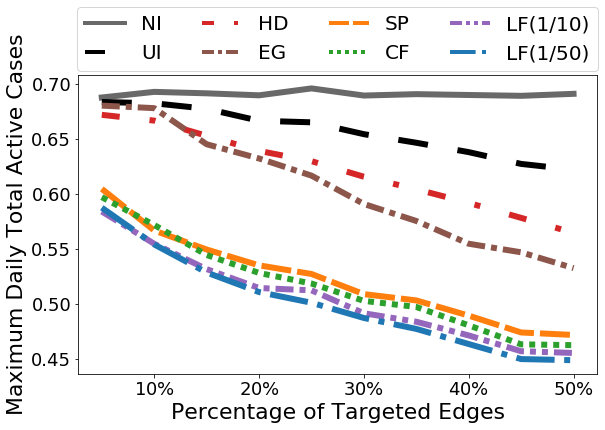

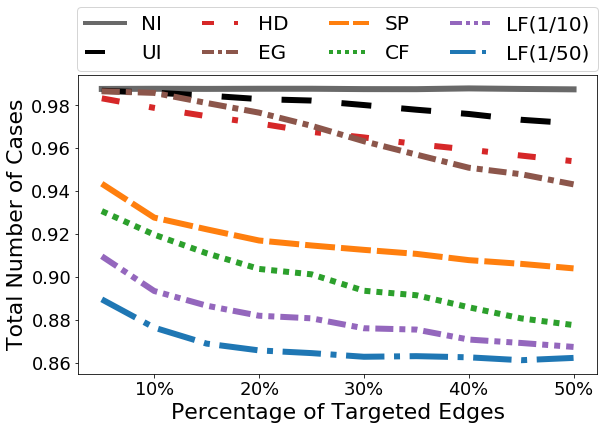

In [23]:
maxCases_ni_mean = np.mean(maxCases_ni/n, axis=0)
maxCases_ui_mean = np.mean(maxCases_ui/n, axis=0)
maxCases_hd_mean = np.mean(maxCases_hd/n, axis=0)
maxCases_eg_mean = np.mean(maxCases_eg/n, axis=0)
maxCases_sp_mean = np.mean(maxCases_sp/n, axis=0)
maxCases_rw_mean = np.mean(maxCases_rw/n, axis=0)
maxCases_lf10_mean = np.mean(maxCases_lf10/n, axis=0)
maxCases_lf02_mean = np.mean(maxCases_lf02/n, axis=0)
totalCases_ni_mean = np.mean(totalCases_ni/n, axis=0)
totalCases_ui_mean = np.mean(totalCases_ui/n, axis=0)
totalCases_hd_mean = np.mean(totalCases_hd/n, axis=0)
totalCases_eg_mean = np.mean(totalCases_eg/n, axis=0)
totalCases_sp_mean = np.mean(totalCases_sp/n, axis=0)
totalCases_rw_mean = np.mean(totalCases_rw/n, axis=0)
totalCases_lf10_mean = np.mean(totalCases_lf10/n, axis=0)
totalCases_lf02_mean = np.mean(totalCases_lf02/n, axis=0)

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, maxCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Maximum Daily Total Active Cases',fontsize=22)
plt.savefig("portlandsub_epipeak_randinit_R045_delay5.png", bbox_inches='tight', format='png', dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label='NI', linestyle='-', color='dimgray', linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label='UI', linestyle=(0,(5,5)), color='k', linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label='HD', linestyle=(0,(3,5,1,5)), color='tab:red', linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label='EG', linestyle=(0,(3,1,1,1)), color='tab:brown', linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label='SP', linestyle=(0,(5,1)), color='tab:orange', linewidth=6)
plt.plot(target_perc, totalCases_rw_mean, label='CF', linestyle=(0,(1,1)), color='tab:green', linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label='LF(1/10)', linestyle=(0,(3,1,1,1,1,1)), color='tab:purple', linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label='LF(1/50)', linestyle='dashdot', color='tab:blue', linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc='upper center', handlelength=2)
for i in leg.legendHandles:
    i.set_linewidth(4)
plt.xticks((.1, .2, .3, .4, .5), ('$10\%$', '$20\%$', '$30\%$', '$40\%$', '$50\%$'), color='k', size=18)
plt.yticks(size=18)
plt.xlabel('Percentage of Targeted Edges', fontsize=22)
plt.ylabel('Total Number of Cases',fontsize=22)
plt.savefig("portlandsub_episize_randinit_R045_delay5.png", bbox_inches='tight', format='png', dpi=400)
plt.show()